## Вихров Евгений Олегович, М-26

## Setup

In [ ]:
# python 3.13.1
# !pip install numpy==2.2.6
# !pip install opencv-python==4.12.0.88
# !pip install pandas==2.3.1
# !pip install pyarrow==21.0.0
# !pip install matplotlib==3.10.6
# !pip install scikit-image==0.25.2


import numpy as np
import matplotlib.pyplot as plt
from skimage import data 
from skimage import io, util, filters
from scipy.spatial.distance import cosine
import pandas as pd
import cv2
import time


## 1)  RGB→Grayscale: веса против простого среднего

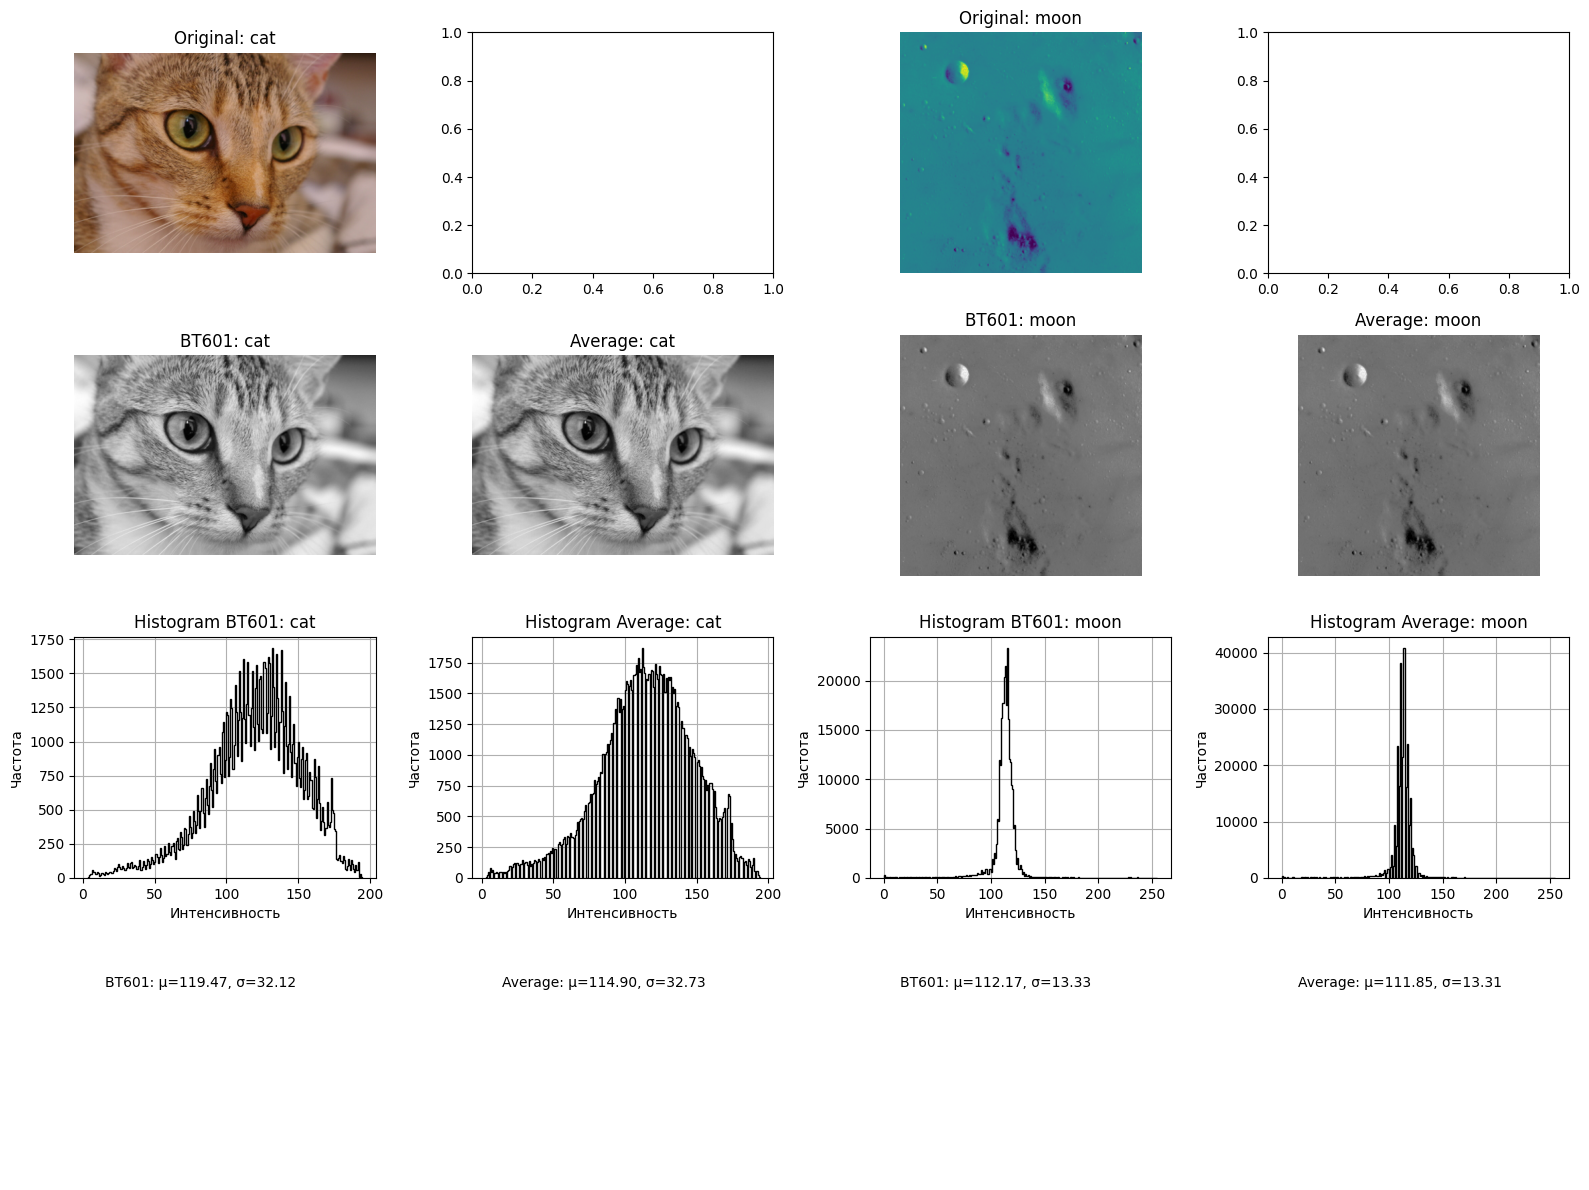

In [14]:
def histogram(image, subplot, title):
    pixel_intensities = image.flatten()
    subplot.hist(pixel_intensities, bins=256, histtype='step', color='k')
    
    subplot.set_title(title)
    subplot.set_xlabel('Интенсивность')
    subplot.set_ylabel('Частота')
    subplot.grid(True)


def statistics(image):
    average_intensity = np.mean(image)
    standard_deviation = np.std(image)
    return average_intensity, standard_deviation

def to_rgb(img):
    # в rgb
    if img.ndim == 2:
        return np.dstack((img,) * 3)
    elif img.ndim == 3 and img.shape[-1] in (3, 4):
        return img[:, :, :3]          
    else:
        raise ValueError("Формат изображения некорректен.")


def grayscale_BT601(rgb_img):
    # Обычный перевод в серый
    greyscale = 0.299 * rgb_img[:, :, 0] + 0.587 * rgb_img[:, :, 1] + 0.114 * rgb_img[:, :, 2]
    return greyscale


def grayscale_native(image):
    # Усредненный перевод в серый
    return np.dot(image[..., :3], [1/3, 1/3, 1/3]).astype(np.uint8)


def main_1(imgs: list = None):
    if imgs is None:
        list_img_from_data = {"cat": data.cat(), "moon": data.moon()}
    else:
        list_img_from_data = {"img1": io.imread(imgs[0]), "img2": io.imread(imgs[1])}
    keys = list(list_img_from_data.keys())

    for key in keys:
        # Переводим в серый 2 методами
        list_img_from_data[f"{key}_bt601"] = grayscale_BT601(to_rgb(list_img_from_data[key]))
        list_img_from_data[f"{key}_avg"] = grayscale_native(to_rgb(list_img_from_data[key]))

    # Рисуем графики и изображения
    _, axes = plt.subplots(4, 4, figsize=(16, 12))

    # Отображаем оригинальные изображения и их grayscale версии
    for i, key in enumerate(keys):
        # Оригинальное изображение
        axes[0, i*2].imshow(list_img_from_data[key])
        axes[0, i*2].set_title(f"Original: {key}")
        axes[0, i*2].axis("off")
        
        # BT601 grayscale
        axes[1, i*2].imshow(list_img_from_data[f"{key}_bt601"], cmap="gray")
        axes[1, i*2].set_title(f"BT601: {key}")
        axes[1, i*2].axis("off")
        
        # Average grayscale
        axes[1, i*2+1].imshow(list_img_from_data[f"{key}_avg"], cmap="gray")
        axes[1, i*2+1].set_title(f"Average: {key}")
        axes[1, i*2+1].axis("off")


    # Гистограммы для каждого метода
    for i, key in enumerate(keys):
        # Гистограмма BT601
        histogram(list_img_from_data[f"{key}_bt601"], axes[2, 2*i], f"Histogram BT601: {key}")
        # Гистограмма Average
        histogram(list_img_from_data[f"{key}_avg"], axes[2, 2*i+1], f"Histogram Average: {key}")

        # Статистика
        bt601_mean, bt601_std = statistics(list_img_from_data[f"{key}_bt601"])
        avg_mean, avg_std = statistics(list_img_from_data[f"{key}_avg"])
        
        # Выводим статистику в заголовки или отдельные текстовые блоки
        axes[3, 2*i].text(0.1, 0.8, f"BT601: μ={bt601_mean:.2f}, σ={bt601_std:.2f}")
        axes[3, 2*i].axis("off")

        axes[3, 2*i+1].text(0.1, 0.8, f"Average: μ={avg_mean:.2f}, σ={avg_std:.2f}")
        axes[3, 2*i+1].axis("off")

    plt.tight_layout()
    plt.show()

# Встроенные изображения
main_1()


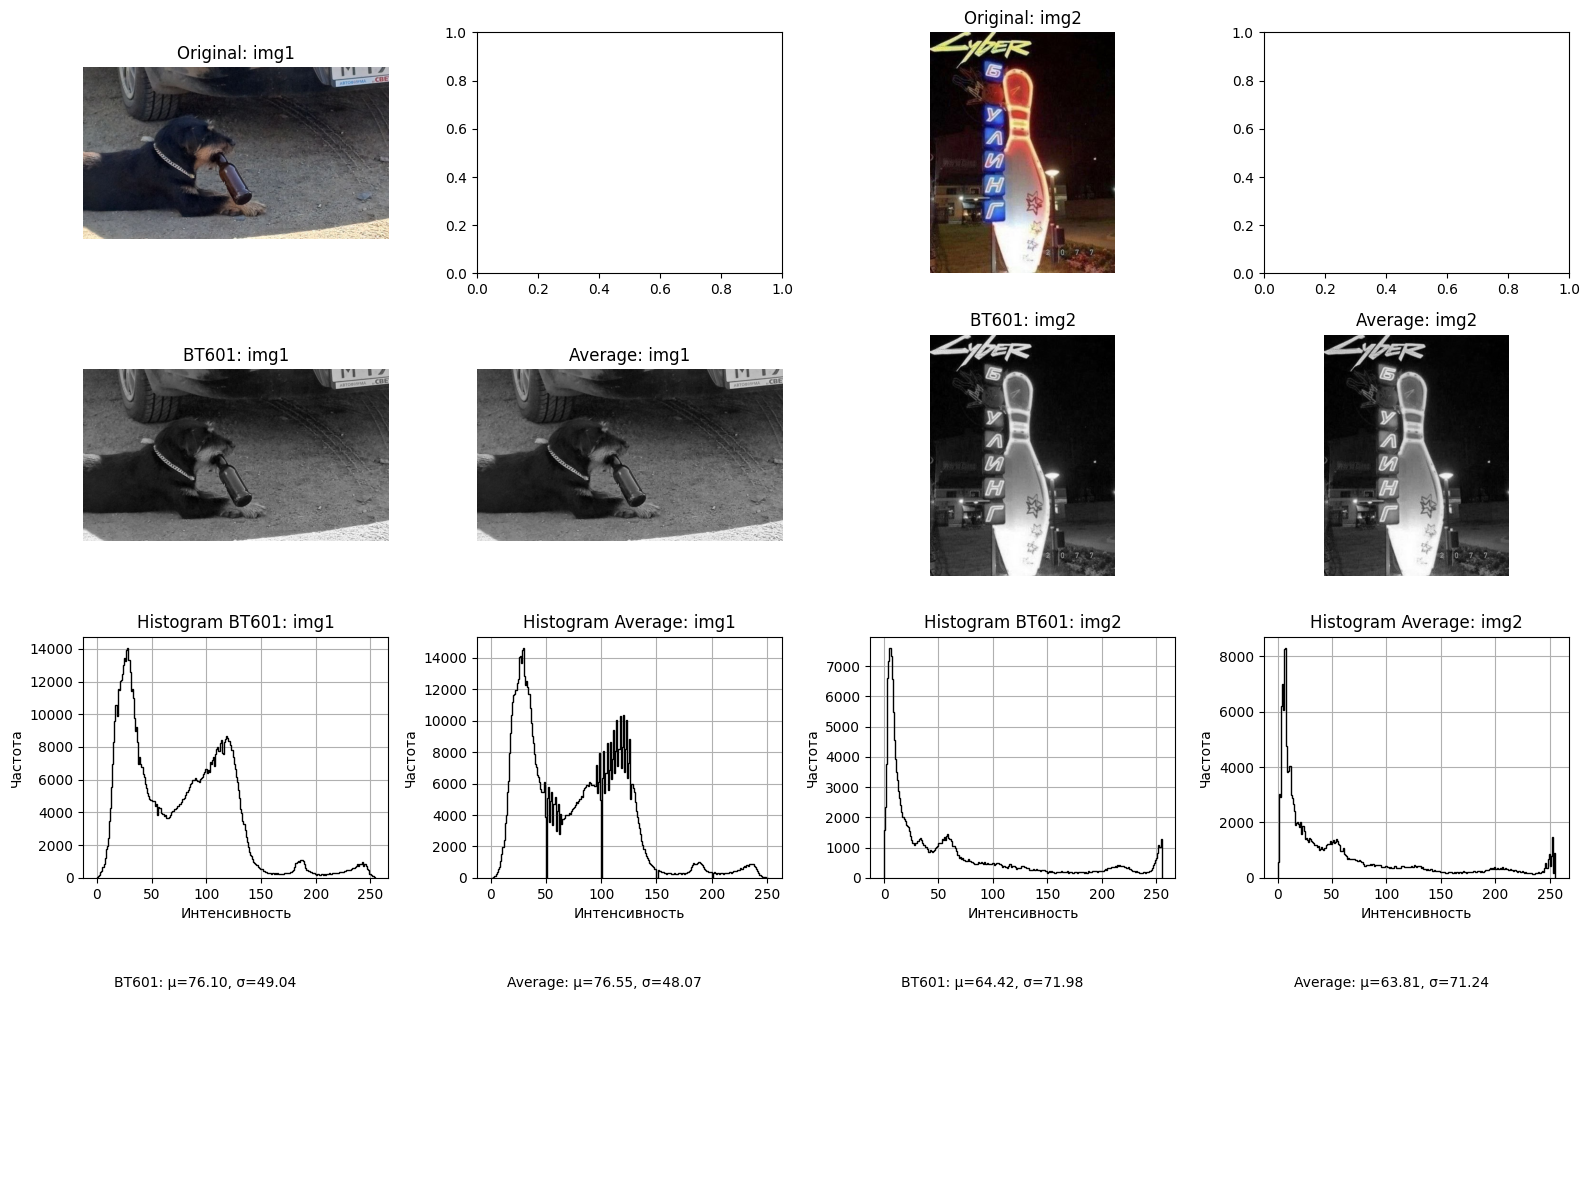

In [15]:
# Свои картинки
imgs = ["./dog.jpg", "./cyber.jpg"]
main_1(imgs)


## Вывод

Оба варианта примерно одинаково переводят изображения в черно-белый формат для человеческого глаза. Исходя из гистограм, можно сделать вывод, что при использовании усредненной формулой появляются "шумы", это связано с неучетом чувствительности глаза различных цветовых каналов. В это время формула BT-601 более точно переводит изображения в черно-белый, так как учитывает различия восприятия цветов человеком.


## Свёртка и фильтры Собела

In [17]:
def calculate_mse(img1, img2):
    # расчет mse
    return np.mean((img1 - img2)**2)

def calculate_psnr(img1, img2):
    # расчет psnr
    mse_val = calculate_mse(img1, img2)
    if mse_val == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse_val))

def custom_convolution(img, kernel, padding_mode):
    # Реализация ручной свертки
    h, w = img.shape
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    
    # Применяем паддинг
    if padding_mode == 'zero':
        padded_img = np.pad(img, [(ph, ph), (pw, pw)], mode='constant', constant_values=0)
    else:
        padded_img = np.pad(img, [(ph, ph), (pw, pw)], mode='reflect')

    # Инициализируем выходное изображение и выполняем свертку
    result = np.zeros_like(img, dtype=np.float64)
    for y in range(h):
        for x in range(w):
            roi = padded_img[y:y+kh, x:x+kw]
            result[y, x] = np.sum(kernel * roi)
            
    return result

def sobel_filters(img, padding):
    # Определяем ядра Собеля
    GX = np.array([[ -1, 0, 1 ],
                   [ -2, 0, 2 ],
                   [ -1, 0, 1 ]], dtype=np.float64)
    
    GY = np.array([[ -1,-2,-1 ],
                   [  0, 0, 0 ],
                   [  1, 2, 1 ]], dtype=np.float64)

    # Вычисляем градиенты
    gradient_x = custom_convolution(img, GX, padding)
    gradient_y = custom_convolution(img, GY, padding)
    
    return np.abs(gradient_x), np.abs(gradient_y)

def main_2(image):
    image = grayscale_BT601(to_rgb(image))  # Преобразование в оттенки серого

    # Расчитываем каждый паддинг
    gx_zero, gy_zero = sobel_filters(image, padding='zero')
    gx_reflect, gy_reflect = sobel_filters(image, padding='reflect')

    # Расчитываем величину и направление для каждого градиента
    mag_zero = np.sqrt(gx_zero**2 + gy_zero**2)
    mag_zero = (mag_zero - mag_zero.min()) / (mag_zero.max() - mag_zero.min())
    mag_zero = util.img_as_ubyte(mag_zero)  
    theta_zero = np.arctan2(gy_zero, gx_zero) 
    theta_zero = (theta_zero - theta_zero.min()) / (theta_zero.max() - theta_zero.min())
    theta_zero = util.img_as_ubyte(theta_zero)

    mag_reflect = np.sqrt(gx_reflect**2 + gy_reflect**2)
    mag_reflect = (mag_reflect - mag_reflect.min()) / (mag_reflect.max() - mag_reflect.min())
    mag_reflect = util.img_as_ubyte(mag_reflect)
    theta_reflect = np.arctan2(gy_reflect, gx_reflect)
    theta_reflect = (theta_reflect - theta_reflect.min()) / (theta_reflect.max() - theta_reflect.min())
    theta_reflect = util.img_as_ubyte(theta_reflect)

    # cv2
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobelx_abs = cv2.convertScaleAbs(sobelx)

    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobely_abs = cv2.convertScaleAbs(sobely)
            
    mag_cv = np.sqrt(sobelx_abs**2 + sobely_abs**2)
    mag_cv = (mag_cv - mag_cv.min()) / (mag_cv.max() - mag_cv.min())
    mag_cv = util.img_as_ubyte(mag_cv)  

    theta_cv = np.arctan2(gy_zero, gx_zero) 
    theta_cv = (theta_zero - theta_zero.min()) / (theta_zero.max() - theta_zero.min())
    theta_cv = util.img_as_ubyte(theta_cv)

    # Оцениваем качество через MSE и PSNR
    mse_mag_zero = calculate_mse(mag_zero, mag_cv)
    mse_mag_reflect = calculate_mse(mag_reflect, mag_cv)

    mse_theta_zero = calculate_mse(theta_zero, theta_cv)
    mse_theta_reflect = calculate_mse(theta_reflect, theta_cv)

    psnr_mag_zero = calculate_psnr(mag_zero, mag_cv)
    psnr_mag_reflect = calculate_psnr(mag_reflect, mag_cv)

    psnr_theta_zero = calculate_psnr(theta_zero, theta_cv)
    psnr_theta_reflect = calculate_psnr(theta_reflect, theta_cv)

    
    plt.figure(figsize=(16, 14))
    plt.subplot(4, 4, 1); plt.imshow(image, cmap='gray'); plt.title('Original')
    plt.subplot(4, 4, 5); plt.imshow(gx_zero, cmap='gray'); plt.title('Zero X')
    plt.subplot(4, 4, 6); plt.imshow(gy_zero, cmap='gray'); plt.title('Zero Y')
    plt.subplot(4, 4, 7); plt.imshow(mag_zero, cmap='gray'); plt.title('Zero Magnitude')
    plt.subplot(4, 4, 8); plt.imshow(theta_zero, cmap='gray'); plt.title('Zero Angle')

    plt.subplot(4, 4, 9); plt.imshow(gx_reflect, cmap='gray'); plt.title('Reflect X')
    plt.subplot(4, 4, 10); plt.imshow(gy_reflect, cmap='gray'); plt.title('Reflect Y')
    plt.subplot(4, 4, 11); plt.imshow(mag_reflect, cmap='gray'); plt.title('Reflect Magnitude')
    plt.subplot(4, 4, 12); plt.imshow(theta_reflect, cmap='gray'); plt.title('Reflect Angle')

    
    plt.subplot(4, 4, 13); plt.imshow(sobelx_abs, cmap='gray'); plt.title('cv2 X')
    plt.subplot(4, 4, 14); plt.imshow(sobely_abs, cmap='gray'); plt.title('cv2 Y')

    text_str = (
    f"MSE Magnitude Zero: {mse_mag_zero:.4f}\n"
    f"MSE Magnitude Reflect: {mse_mag_reflect:.4f}\n"
    f"MSE Theta Zero: {mse_theta_zero:.4f}\n"
    f"MSE Theta Reflect: {mse_theta_reflect:.4f}\n"
    f"PSNR Magnitude Zero: {psnr_mag_zero:.2f}\n"
    f"PSNR Magnitude Reflect: {psnr_mag_reflect:.2f}\n"
    f"PSNR Theta Zero: {psnr_theta_zero:.2f}\n"
    f"PSNR Theta Reflect: {psnr_theta_reflect:.2f}"
    )
    plt.subplot(4, 4, 2); plt.axis('off');plt.text(0.5, 0.5, text_str, fontsize=12, ha='center', va='center')

    plt.show()

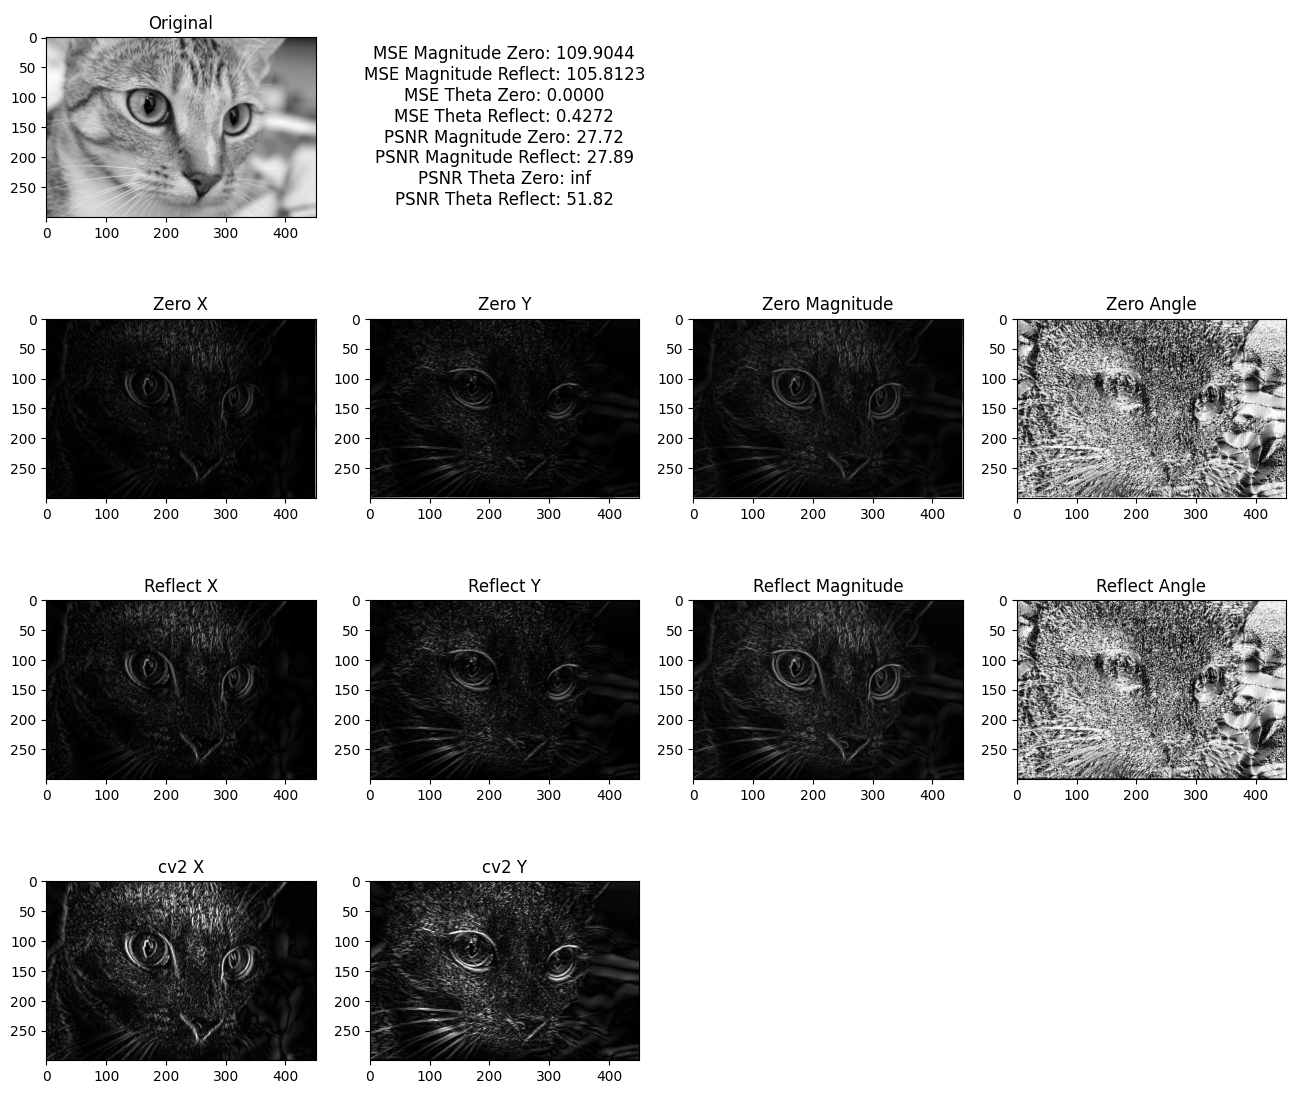

In [18]:
# 1 картинка
image = data.cat()
main_2(image)

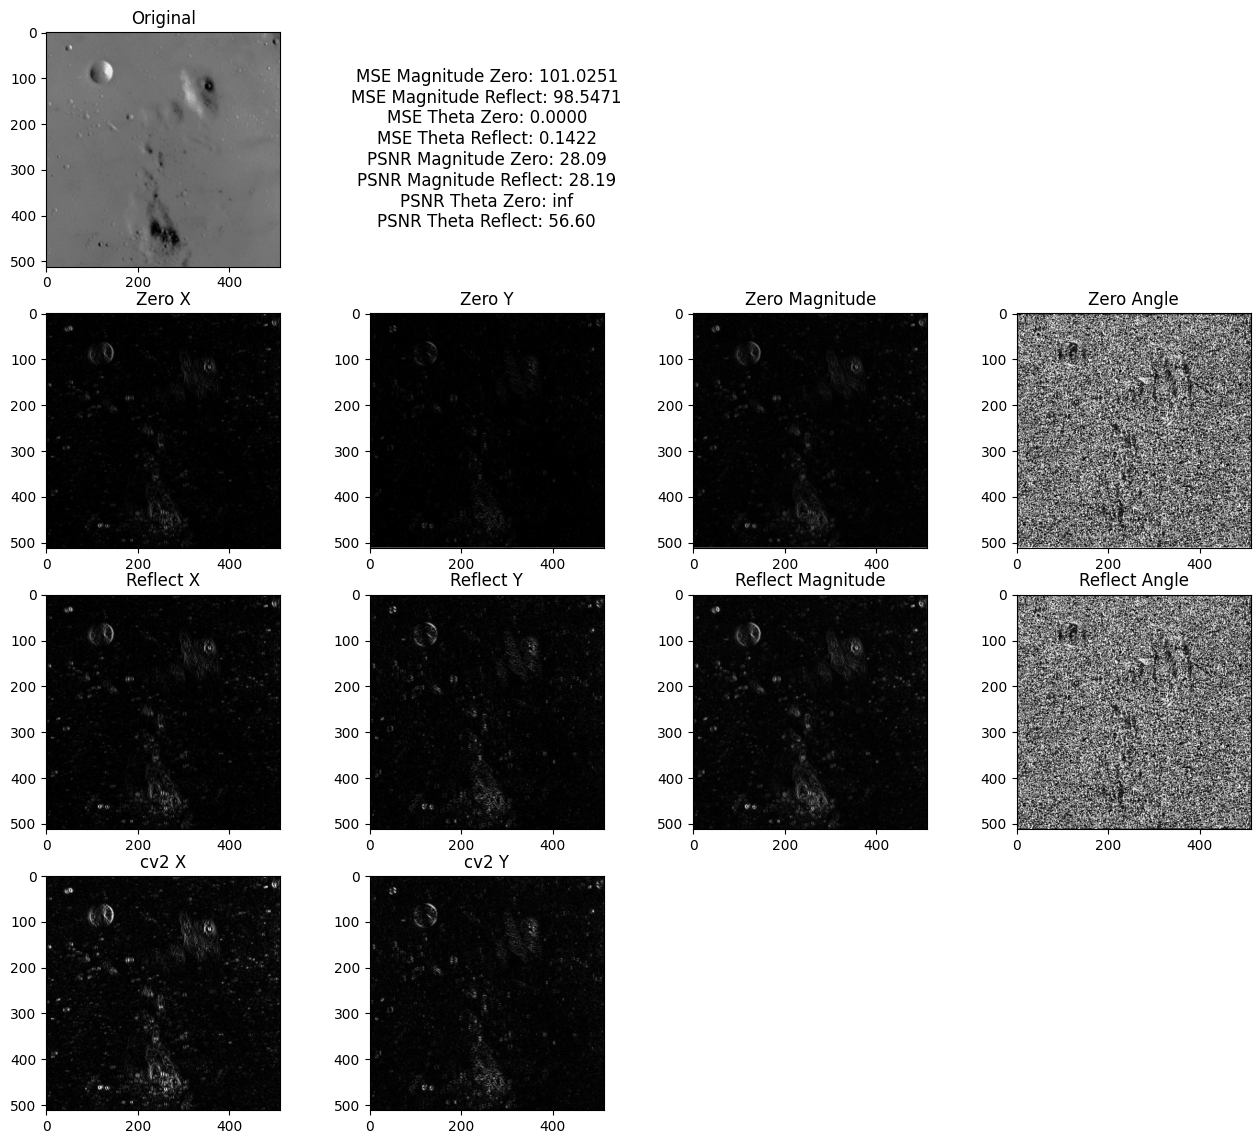

In [19]:
# 2 картинка
image2 = data.moon()
main_2(image2)


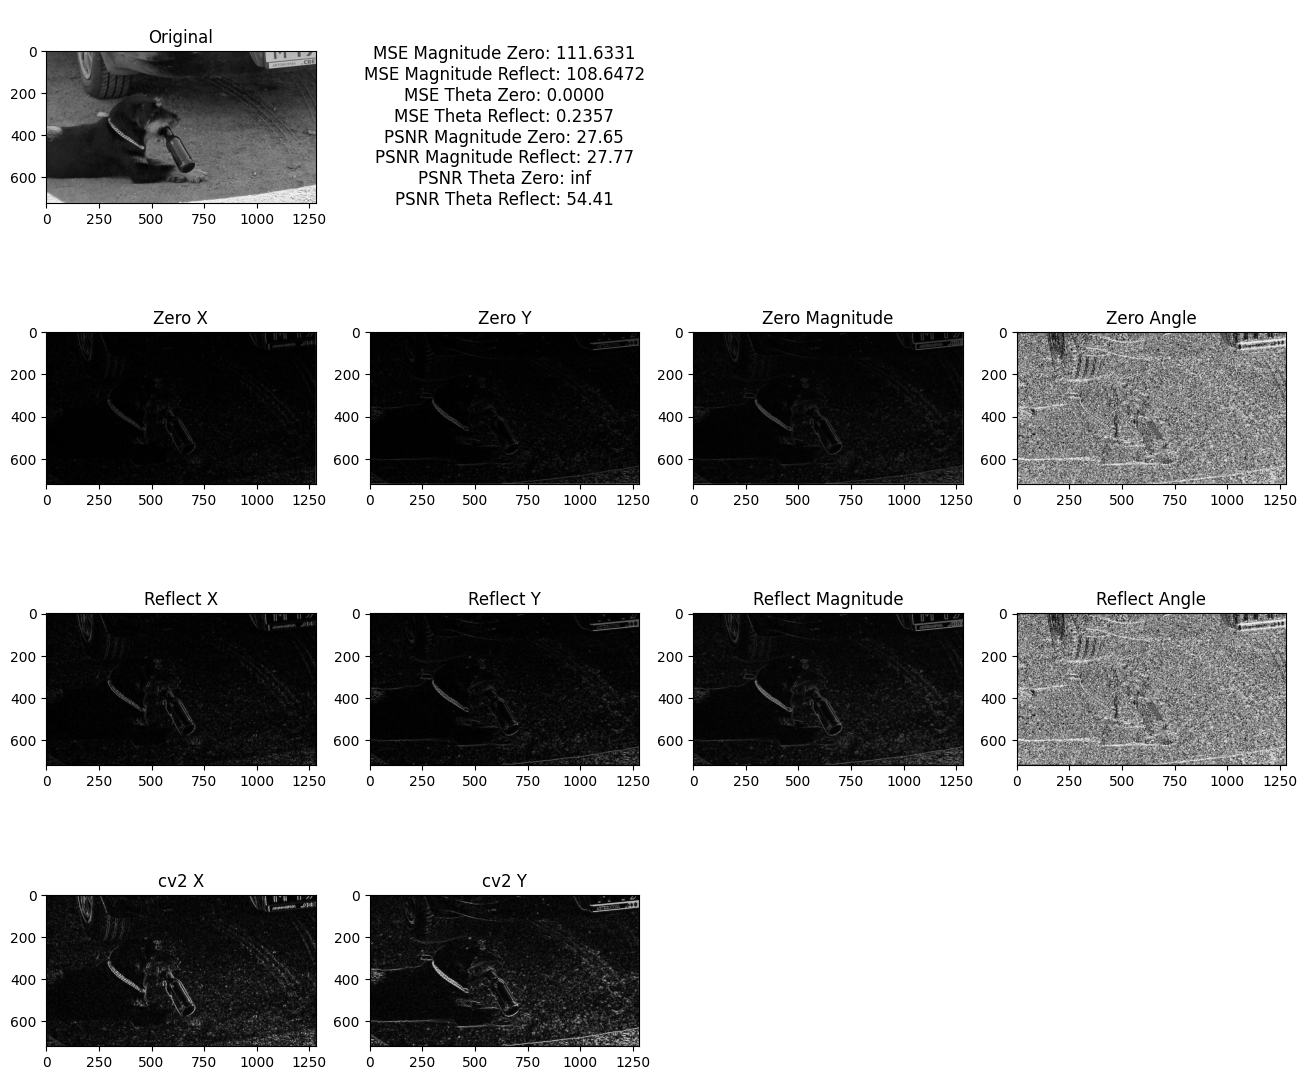

In [20]:
# 3 картинка
image = io.imread(imgs[0])
main_2(image)

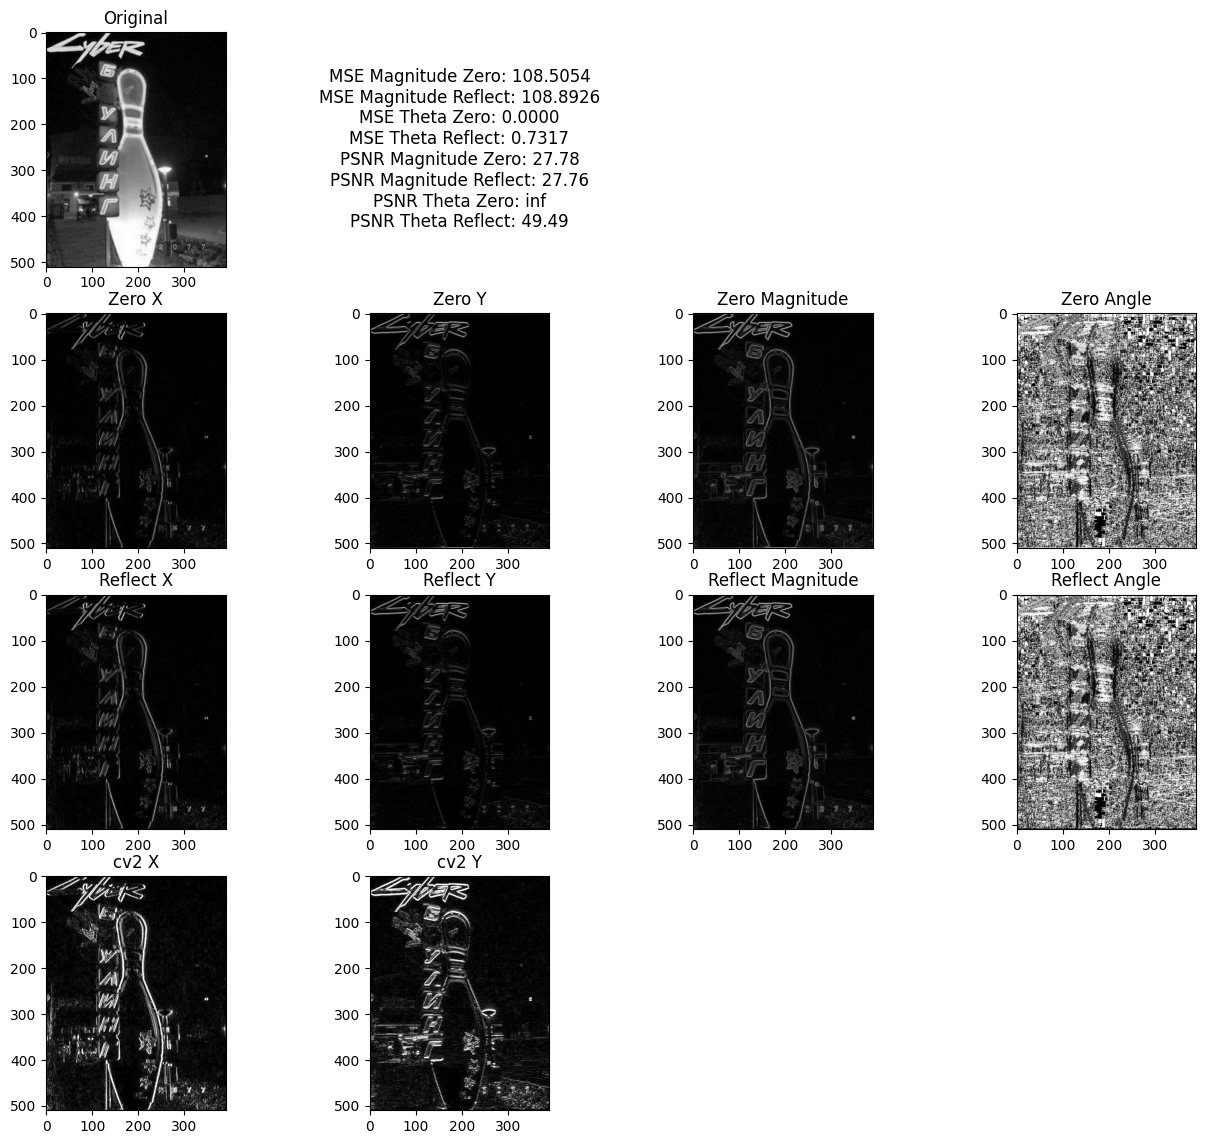

In [21]:
# 4 картинка
image = io.imread(imgs[1])
main_2(image)

## Выводы

Результаты работы свертки из cv2 выделяет более четкие и ярковыраженные границы на объектах в изображениях. Паддинг zero, в собственной реализации, не захватывает границы объектов, расположенные ближе к краям изображения (отлично видно на картинке с котом). Reflect с этим справляется лучше, а также захватывает границы на размытых объектах (хорошо видно по картинке с собакой). 

## Canny руками: NMS и гистерезис

Text(0.5, 1.0, '1.4')

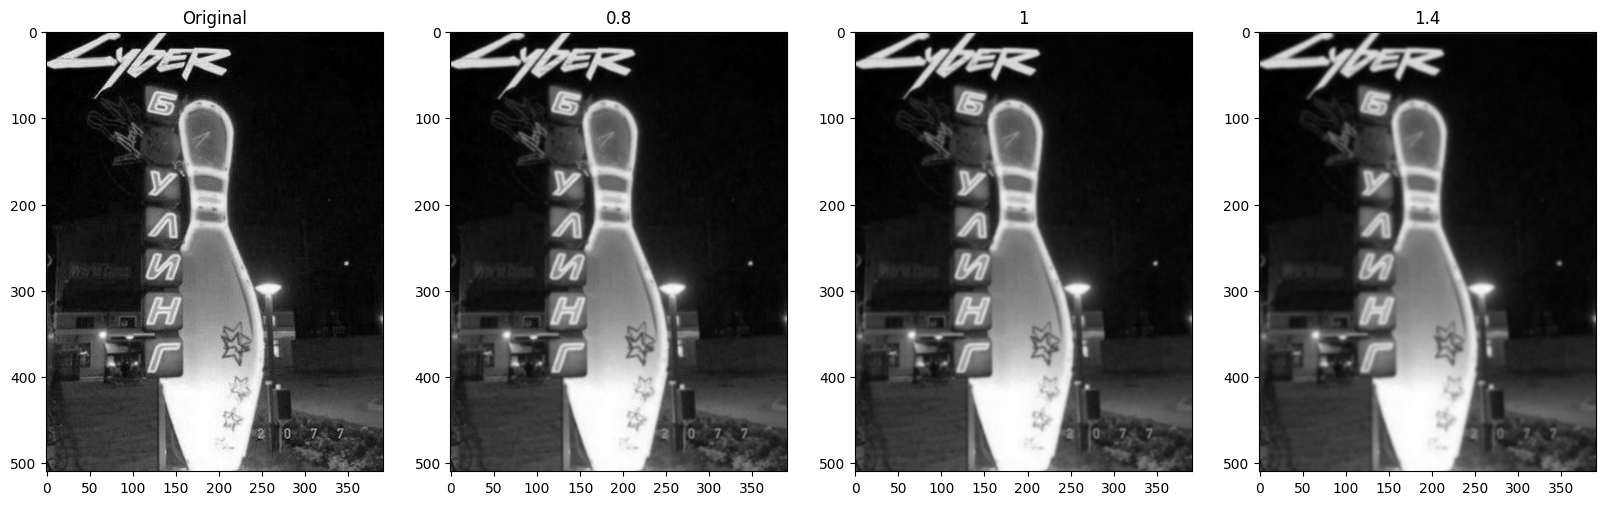

In [22]:
image = io.imread(imgs[1])
image = grayscale_BT601(to_rgb(image))

blurred_0_8 = filters.gaussian(image, sigma=0.8, channel_axis=None)
blurred_1 = filters.gaussian(image, sigma=1, channel_axis=None)
blurred_1_4 = filters.gaussian(image, sigma=1.4, channel_axis=None)

plt.figure(figsize=(20, 14))
plt.subplot(1, 4, 1); plt.imshow(image, cmap='gray'); plt.title('Original')
plt.subplot(1, 4, 2); plt.imshow(blurred_0_8, cmap='gray'); plt.title('0.8')
plt.subplot(1, 4, 3); plt.imshow(blurred_1, cmap='gray'); plt.title('1')
plt.subplot(1, 4, 4); plt.imshow(blurred_1_4, cmap='gray'); plt.title('1.4')

Для начала нужно подобрать параметр σ так, чтобы зашумленные участки изображения классифицировались, как шум, а остальные границы объектов выделялись, как нормальные

In [ ]:
def suppress_non_maxima(magnitude_map, gradient_direction, lower_threshold=None, upper_threshold=None):
    """
    Выполняет подавление немаксимальных значений и бинаризацию краев методом двойного порога.
    """
    rows, cols = magnitude_map.shape
    edges_suppressed = np.zeros_like(magnitude_map)
    
    # Квантование углов градиента на четыре главных направления (0°, 45°, 90°, 135°)
    quantized_angles = np.zeros_like(gradient_direction)
    angles_in_degrees = np.degrees(gradient_direction) % 180
    
    # Назначаем каждому направлению квантованное значение угла
    quantized_angles[
        (angles_in_degrees >= 0) & (angles_in_degrees < 22.5) |
        (angles_in_degrees >= 157.5) & (angles_in_degrees <= 180)
    ] = 0  # Горизонтально (0°)
    
    quantized_angles[
        (angles_in_degrees >= 22.5) & (angles_in_degrees < 67.5)
    ] = 1  # Диагональ вверх-вправо (45°)
    
    quantized_angles[
        (angles_in_degrees >= 67.5) & (angles_in_degrees < 112.5)
    ] = 2  # Вертикально (90°)
    
    quantized_angles[
        (angles_in_degrees >= 112.5) & (angles_in_degrees < 157.5)
    ] = 3  # Диагональ вверх-влево (135°)
    
    # Подавление немаксимумов путём проверки соседних точек
    for row in range(1, rows-1):
        for col in range(1, cols-1):
            current_mag = magnitude_map[row, col]
            if current_mag == 0:
                continue
            
            current_angle = quantized_angles[row, col]
            
            # Выбор соседей согласно направлению градиента
            if current_angle == 0:  # Горизонтальное направление
                neighbours = [magnitude_map[row, col-1], magnitude_map[row, col+1]]
            elif current_angle == 1:  # Диагональ вправо-вверх
                neighbours = [magnitude_map[row-1, col-1], magnitude_map[row+1, col+1]]
            elif current_angle == 2:  # Вертикальное направление
                neighbours = [magnitude_map[row-1, col], magnitude_map[row+1, col]]
            else:                     # Диагональ влево-вниз
                neighbours = [magnitude_map[row-1, col+1], magnitude_map[row+1, col-1]]
            
            # Проверка максимальности текущего значения среди соседей
            if current_mag >= max(neighbours):
                edges_suppressed[row, col] = current_mag
    
    # Двойной порог для разделения сильных и слабых краёв
    if lower_threshold is None:
        lower_threshold = 0.05
    if upper_threshold is None:
        upper_threshold = 0.15
    
    strong_edges = edges_suppressed > upper_threshold
    weak_edges = (edges_suppressed >= lower_threshold) & (edges_suppressed <= upper_threshold)
    
    # Связывание слабых краев через сильные (гистерезис)
    final_result = strong_edges.copy()
    changes_occured = True
    
    while changes_occured:
        changes_occured = False
        for r in range(1, rows-1):
            for c in range(1, cols-1):
                if weak_edges[r,c] and not final_result[r,c]:
                    if np.any(final_result[r-1:r+2, c-1:c+2]):
                        final_result[r,c] = True
                        changes_occured = True
                        
    return final_result.astype(np.uint8) * 255

def determine_thresholds(magnitude_map):
    """
    Автоматически определяет нижний и верхний пороги по данным распределения интенсивностей градиента.
    """
    plt.hist(magnitude_map.flatten(), bins=100)
    
    # Определённые процентили для автоматического выбора порогов
    lower_threshold = np.percentile(magnitude_map, 80)   
    upper_threshold = np.percentile(magnitude_map, 90)  
    
    return lower_threshold, upper_threshold

def extract_edges(image, gaussian_sigmas, lower_threshold=None, upper_threshold=None):
    """
    Основная функция обнаружения контуров по алгоритму Канни с возможностью задания разных сигм гауссовых фильтров.
    """
    original_gray = grayscale_BT601(to_rgb(image))
    
    for sigma in gaussian_sigmas:
        # Сглаживание изображения с применением фильтра Гаусса
        blurred_image = cv2.GaussianBlur(image, (5, 5), sigma)
        processed_gray = grayscale_BT601(to_rgb(blurred_image))
        
        # Вычисление карты градиентов оператором Собеля
        horizontal_gradient, vertical_gradient = sobel_filters(processed_gray, "reflect")
        gradient_magnitude = np.sqrt(horizontal_gradient**2 + vertical_gradient**2)
        gradient_direction = np.arctan2(vertical_gradient, horizontal_gradient) * (180 / np.pi)
        
        # Определение автоматических порогов, если они не предоставлены вручную
        if lower_threshold is None or upper_threshold is None:
            lower_threshold, upper_threshold = determine_thresholds(gradient_magnitude)
            
        print(lower_threshold, upper_threshold)
        
        # Подавление немаксимумов и получение финального набора краёв
        detected_edges = suppress_non_maxima(gradient_magnitude, gradient_direction, lower_threshold, upper_threshold)
        
        # Получение результата детекции контуров из OpenCV для сравнения
        opencv_edge_result = compare_with_opencv(original_gray, lower_threshold, upper_threshold)
        
        # Создание фигуры для визуализации этапов процесса
        plt.figure(figsize=(10, 10))
        
        # Отображение этапа сглаживания изображения
        plt.subplot(2, 3, 1)
        plt.imshow(processed_gray, cmap='gray')
        plt.title(f'Smoothing with Gaussian Filter (σ={sigma})')
        
        # Карта градиентов (магнитудная)
        plt.subplot(2, 3, 2)
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title('Gradient Magnitude Map')
        
        # Финальные обнаруженные контуры
        plt.subplot(2, 3, 4)
        plt.imshow(detected_edges, cmap='gray')
        plt.title('Detected Edges by Custom Algorithm')
        
        # Контуры, полученные библиотекой OpenCV
        plt.subplot(2, 3, 5)
        plt.imshow(opencv_edge_result, cmap='gray')
        plt.title('Edges Detected by OpenCV')
        
        plt.show()

def compare_with_opencv(grayscale_image, lower_threshold, upper_threshold):
    """
    Возвращает результат детектирования контуров функцией Canny из библиотеки OpenCV.
    """
    normalized_image = np.clip(grayscale_image, 0, 255).astype(np.uint8)
    edge_result = cv2.Canny(normalized_image, lower_threshold, upper_threshold)
    return edge_result

55.354059008305185 93.1613477549155


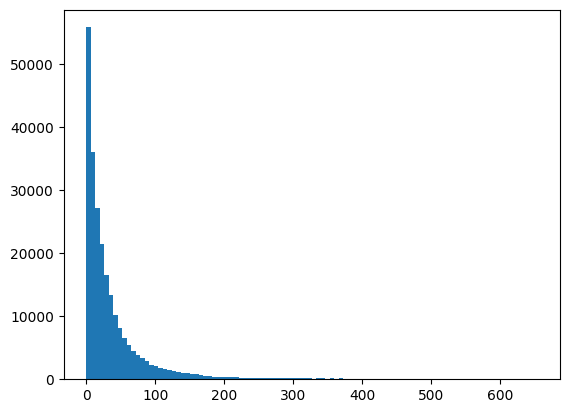

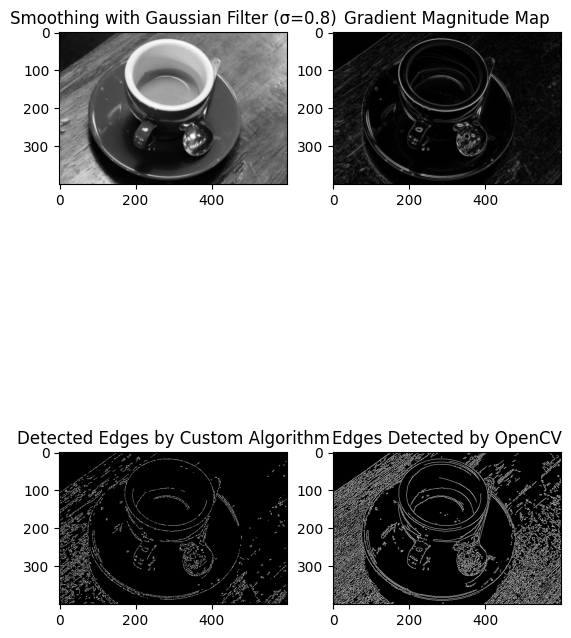

55.354059008305185 93.1613477549155


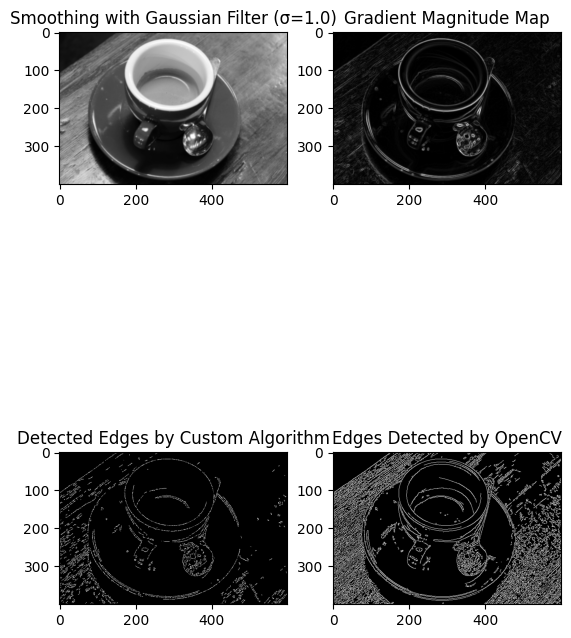

55.354059008305185 93.1613477549155


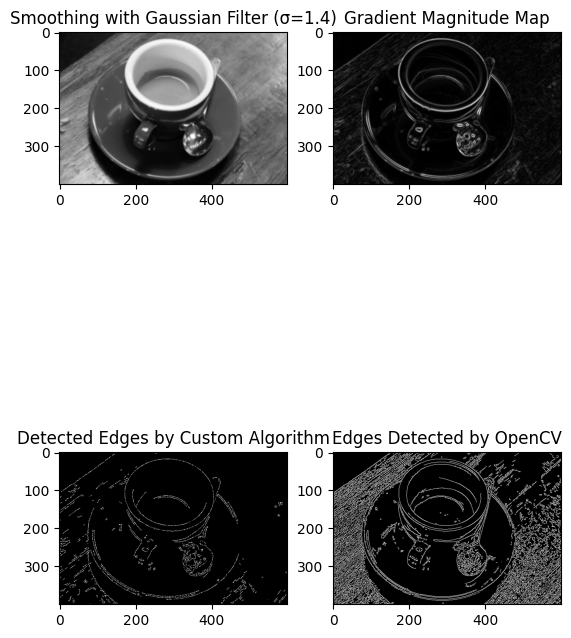

In [61]:
# Запуск функции
extract_edges(data.coffee(), [0.8, 1.0, 1.4])

Значения для 0.8: 55.354059008305185 93.1613477549155

Значения для 1: 49.73036212562583 84.21803567035329

Значения для 1.4: 43.877883421990845 75.54358085139093

Я подобрал параметры нижнего и вверхнего порога равные 80 и 90 процентов, так как данные значения позволяют избавиться от излишнего шума и сохранить границы выделяемых объектов читабельными: деревянный стол потерял большую часть своего рельефа, оставив только небольшие его части, но при этом чашка и ложка остались хорошо различимы после обработки. С увеличением предварительного размытия изображения мелких деталей становится все меньше, поэтому нужно найти баланс, чтобы "не затереть" границы объектов. Теперь попробуем извлечь только морду кота, подобрав параметры сигмы, вверхней и нижней границы.

55 80


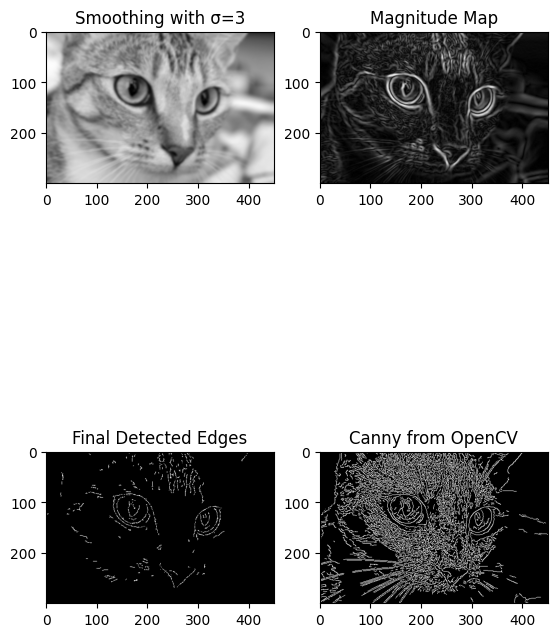

In [115]:
# Параметры для теста
image = data.cat()
sigma_values = [3]

# Запуск функции
detect_edges(image, sigma_values, 55, 80)

Я пытался подобрать параметры так, чтобы после обработки изображения остались примерные очертания границ морды и основных черт кота, но не вобрало в себя излишнюю детализацию шерсти. По итогу остановился на следующих значениях параметров:

σ = 3

Нижняя граница 55 

Вверхняя граница 80

## HOG-дескриптор: ячейки, бининги, нормировка L2-Hys

In [117]:
def compute_gradients(image):
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    M = np.sqrt(Ix**2 + Iy**2)
    Theta = np.arctan2(Iy, Ix) * 180 / np.pi
    Theta = (Theta + 180) % 180
    
    return Ix, Iy, M, Theta

def compute_hog(image, cell_size=8, block_size=2, nbins=9, norm='L2-Hys', eps=1e-5):
    # Вычисление HOG-дескриптора
    # Вычисление градиентов
    _, _, M, Theta = compute_gradients(image)
    height, width = image.shape
    
    # Параметры разбиения на ячейки
    bin_step = 180 / nbins
    cells_height = height // cell_size
    cells_width = width // cell_size
    
    # Инициализация гистограмм для ячеек
    cell_histograms = np.zeros((cells_height, cells_width, nbins))
    
    # Построение гистограмм ориентированных градиентов для каждой ячейки
    for i in range(height):
        for j in range(width):
            cell_i = i // cell_size
            cell_j = j // cell_size
            
            if cell_i >= cells_height or cell_j >= cells_width:
                continue
            
            # Билинейное интерполирование по ориентациям
            bin_idx = Theta[i, j] // bin_step
            bin_fraction = (Theta[i, j] % bin_step) / bin_step
            bin_idx = int(bin_idx) % nbins
            next_bin = (bin_idx + 1) % nbins
            
            cell_histograms[cell_i, cell_j, bin_idx] += M[i, j] * (1 - bin_fraction)
            cell_histograms[cell_i, cell_j, next_bin] += M[i, j] * bin_fraction
    
    # Нормализация по блокам
    blocks_height = cells_height - block_size + 1
    blocks_width = cells_width - block_size + 1
    
    hog_descriptor = []
    
    for i in range(blocks_height):
        for j in range(blocks_width):
            block = cell_histograms[i:i+block_size, j:j+block_size].flatten()
            
            if norm == 'L2':
                norm_value = np.sqrt(np.sum(block**2) + eps**2)
                block /= norm_value
            elif norm == 'L2-Hys':
                # L2-нормализация с последующим ограничением и повторной нормализацией
                norm_value = np.sqrt(np.sum(block**2) + eps**2)
                block /= norm_value
                block = np.clip(block, 0, 0.2)
                norm_value = np.sqrt(np.sum(block**2) + eps**2)
                block /= norm_value
            
            hog_descriptor.extend(block)
    
    return np.array(hog_descriptor)

def visualize_hog(image, hog, cell_size=8, nbins=9):
    # Визуализация HOG-дескриптора
    height, width = image.shape
    cells_height = height // cell_size
    cells_width = width // cell_size
    
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(image, cmap='gray')
    ax.set_title('HOG Visualization')
    ax.axis('off')
    
    # Визуализация стрелок для каждой ячейки
    for i in range(cells_height):
        for j in range(cells_width):
            center_y = i * cell_size + cell_size // 2
            center_x = j * cell_size + cell_size // 2
            
            for bin_idx in range(nbins):
                angle = bin_idx * (180 / nbins) * np.pi / 180
                magnitude = hog[i * cells_width * nbins + j * nbins + bin_idx]
                
                dx = magnitude * np.cos(angle) * 10
                dy = magnitude * np.sin(angle) * 10
                
                ax.arrow(center_x, center_y, dx, dy, 
                        head_width=3, head_length=2, 
                        fc='red', ec='red', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def compare_hog_configurations(image, base_config, test_configs):
    # Сравнение различных конфигураций HOG
    results = []
    
    # Вычисление базового дескриптора
    start_time = time.time()
    base_hog = compute_hog(image, **base_config)
    base_time = time.time() - start_time
    
    results.append({
        'config': base_config,
        'dimension': len(base_hog),
        'time': base_time,
        'hog': base_hog,
        'similarity': 1.0 
    })
    
    # Вычисление дескрипторов для тестовых конфигураций
    for config in test_configs:
        start_time = time.time()
        hog = compute_hog(image, **config)
        elapsed_time = time.time() - start_time
        
        # Вычисление косинусного сходства с базовой конфигурацией
        min_length = min(len(base_hog), len(hog))
        similarity = 1 - cosine(base_hog[:min_length], hog[:min_length])
        
        results.append({
            'config': config,
            'dimension': len(hog),
            'time': elapsed_time,
            'hog': hog,
            'similarity': similarity
        })
    
    return results

def plot_configuration_comparison(image, results, cell_size=8, nbins=9):
    # Визуализация сравнения конфигураций с отображением HOG
    _, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    for idx, result in enumerate(results):
        ax = axes[idx // 2, idx % 2]
        
        # Визуализация HOG на изображении
        visualize_hog_on_axis(ax, image, result['hog'], 
                             result['config']['cell_size'], 
                             result['config']['nbins'])
        
        config = result['config']
        title = (f"Cell {config['cell_size']}x{config['cell_size']}, "
                f"{config['nbins']} bins, {config['norm']}\n"
                f"Dim: {result['dimension']}, Time: {result['time']:.4f}s")
        
        if 'similarity' in result:
            title += f"\nSimilarity: {result['similarity']:.4f}"
        
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_hog_on_axis(ax, image, hog, cell_size=8, nbins=9):
    # Визуализация HOG на переданной оси
    height, width = image.shape
    cells_height = height // cell_size
    cells_width = width // cell_size
    
    ax.imshow(image, cmap='gray')
    
    # Визуализация стрелок для каждой ячейки
    for i in range(cells_height):
        for j in range(cells_width):
            center_y = i * cell_size + cell_size // 2
            center_x = j * cell_size + cell_size // 2
            
            for bin_idx in range(nbins):
                angle = bin_idx * (180 / nbins) * np.pi / 180
                magnitude = hog[i * cells_width * nbins + j * nbins + bin_idx]
                
                # Масштабируем величину для лучшей визуализации
                dx = magnitude * np.cos(angle) * cell_size * 0.8
                dy = magnitude * np.sin(angle) * cell_size * 0.8
                
                ax.arrow(center_x, center_y, dx, dy, 
                        head_width=2, head_length=2, 
                        fc='red', ec='red', alpha=0.7, width=0.5)
                

def create_results_table(results):
    # Создание таблицы результатов
    results_table = []
    for result in results:
        config = result['config']
        results_table.append({
            'Cell Size': f"{config['cell_size']}x{config['cell_size']}",
            'Bins': config['nbins'],
            'Normalization': config['norm'],
            'Dimension': result['dimension'],
            'Time (s)': round(result['time'], 4),
            'Similarity': round(result.get('similarity', 1.0), 4)
        })
    
    return pd.DataFrame(results_table)

def main_4():
    image = data.cat()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)

    # Вычисление и визуализация HOG для базовой конфигурации
    base_hog = compute_hog(image)
    visualize_hog(image, base_hog)
    
    # Конфигурации для сравнения
    base_config = {'cell_size': 8, 'nbins': 9, 'norm': 'L2-Hys'}
    
    test_configs = [
        {'cell_size': 16, 'nbins': 9, 'norm': 'L2-Hys'},
        {'cell_size': 8, 'nbins': 12, 'norm': 'L2-Hys'},
        {'cell_size': 8, 'nbins': 9, 'norm': 'L2'},
    ]
    
    # Сравнение конфигураций
    results = compare_hog_configurations(image, base_config, test_configs)
    plot_configuration_comparison(image, results)
    
    # Создание и вывод таблицы результатов
    df = create_results_table(results)
    print(df.to_string(index=False))


In [ ]:
main_4()

Возьмем разбиение 8x8, 9 бинов и L2-Hys нормализацию как "эталон" и сравним то, как подбор параметров повлияет на итоговый результат.

Разбиение 16x16: в результате было утеряно большое число мелких объектов, усреднив градиенты границ в более крупных ячейках разбиения изображения. Мы потеряли в схожести результатах, но затратили меньше времени на вычисления и размерности блоков. Может быть полезно, если нужно обрабатывать большое изображение или нужно считывать крупные объекты.

Бины 12: мы затрачиваем большее число размерности дескриптора, но начинаем различать объекты более качественно в плане ориентации градинтов.

Нормализация L2: данная нормализация хуже улавливает резкие перепады со светом в изображениях, но затрачивает меньше вычислительных ресурсов.  

### 1. Разница между «операцией свёртки» и «обучаемым свёрточным слоем»:

Операция свертки происходит фильтру, который известен изначально. Обучаемый сверточный фильтр сам подбирает значения ядра во время обучения.

### 2. Почему atan2 предпочтительнее arctan(Iy/Ix) для углов градиента?

atan2(Iy, Ix) учитывает знаки обеих компонент, что позволяет определять угол в полном диапазоне 360°. arctan(Iy/Ix) имеет разрывы при Ix равном 0 и работает только в диапазоне 180°.

### 3. Почему шаблон 1–2–1 в Sobel снижает влияние шума?

Данный шаблон работает как усреднение с упорм на центральный пиксель, что позовляет сделать плавное взвешивание пикселей. В следствие этого, снижается влияние шума.

### 4. Чем плох глобальный единый порог по M, и как гистерезис это исправляет?

Глобальный порог либо сохраняет слабые границы с шумом (при низком пороге), либо теряет важные слабые границы (при высоком). Гистерезис использует два порога: сильные границы автоматически сохраняются, а слабые — только если соединены с сильными, что сохраняет непрерывность границ при эффективном подавлении шума.

### 5. Ограничения HOG и способы частичной компенсации масштабной чувствительности:

HOG обладает выраженной чувствительностью к масштабным изменениям объектов из-за фиксированных размеров ячеек и блоков, что приводит к значительному ухудшению распознавания при работе с разноразмерными объектами. Для частичной компенсации этого недостатка применяются пирамиды изображений, где дескрипторы вычисляются на нескольких масштабах, а также мультискейл-подходы с детектированием на разных уровнях разрешения, однако эти методы существенно увеличивают вычислительную сложность алгоритма.
